In this notebook we examine what probes are conserved over age. The processing of the data for humans are shown in the dataprocessing notebook. We compare the commonly profiled space by using liftOver. Liftover is called using liftOver -minMatch=0.1 lifting mm10 to hg19 after stripping the 'chr' from the chain files. We liftOver from mouse to human and intersect the commonly profiled space using intersectBed. These files are then parsed. A site is commonly profiled if it intersects the region that is probed (this decision was made because some of these probes on the 450K assume a methylation state within a 50bp region) in the respective species's genomic space. If there is a many to one mapping then we take the average of sites that are commonly profiled. Everything is done in Illumina450K probe namespace.

### Notebook imports

In [1]:
from __future__ import division
import os
import numpy as np
import random 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline
import collections

import imp
twto = imp.load_source('twto','scripts/twang_toolbox.py')
meth = imp.load_source('meth','scripts/methy_parsing.py')

from sklearn import cross_validation, linear_model, metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats as smstats
import scipy.stats as stats
import scipy.cluster.hierarchy as hac

In [2]:
#Used for paper
sns.set(context = "paper", style='ticks',rc={"font.size":9,"legend.fontsize":8,"axes.titlesize":12,
                             "axes.labelsize":8,"xtick.labelsize":6,"ytick.labelsize":6, 'xtick.major.size': 3.0,
 'xtick.minor.size': 1.0,'ytick.major.size': 3.0,
 'ytick.minor.size': 1.0})

In [2]:
sns.set(context = "notebook", style='white')

#### functions used for this analysis

In [3]:
def match_site2probe(file_dict):
    site2probe_dict = collections.defaultdict(set)
    for cat in file_dict.keys():
        intersectf = file_dict[cat]
        lines_intersects = twto.read_file(intersectf)
        #dict_sites = {x[3]:x[-1] for x in lines_intersects}
        print cat,len(set([x[3] for x in lines_intersects])),len(set([x[-1] for x in lines_intersects]))
        for row in lines_intersects:
            site2probe_dict[row[-1]].add(row[3])
    return(site2probe_dict)

In [4]:
def collapse_mouse_2human_probe(df_reizelonly,site2probe):
    mouse_to_probes_df_bg = []
    corr_per_site_bg = []
    for probe in site2probe:
        mouse_sites = list(site2probe[probe])
        average_sites = df_reizelonly.loc[:,mouse_sites].mean(axis=1)
        if len(mouse_sites)>1:
            average_sites_corr = df_reizelonly.loc[:,mouse_sites].corr().iloc[0,1:].mean()
            average_sites_difference = df_reizelonly.loc[:,mouse_sites].diff(axis=1).mean().mean()
            corr_per_site_bg.append([probe,average_sites_corr,average_sites_difference,len(mouse_sites)])
        average_sites.name = probe
        mouse_to_probes_df_bg.append(average_sites)
    df_reizel_ps = pd.concat(mouse_to_probes_df_bg,axis=1)
    corr_ps = pd.DataFrame(corr_per_site_bg,columns=['probe','corr','average_diff','lensites'])
    return(df_reizel_ps,corr_ps)

In [5]:
def calculate_odds_ratio_removeoverlapping(all_features_allsites_notf_crossab,age_features):
    counts= []
    not_agefeatures = all_features_allsites_notf_crossab.index.difference(age_features)
    #ttfreq = pd.concat([all_features_allsites_notf_crossab.loc[age_features].sum(),all_features_allsites_notf_crossab.loc[not_agefeatures].sum()]
    #      ,axis=1,keys=['AgeFeatures','NotAgeFeatures'])
    for feature in all_features_allsites_notf_crossab.columns:
        feature_sites = all_features_allsites_notf_crossab[all_features_allsites_notf_crossab[feature]==1].index
        notfeature_sites = all_features_allsites_notf_crossab[all_features_allsites_notf_crossab[feature]==0].index.difference(feature_sites)
        feature_sites_age = feature_sites.intersection(age_features)
        features_sites_notage = feature_sites.difference(age_features)
        notfeature_sites_age = notfeature_sites.intersection(age_features)
        notfeature_sites_notage = notfeature_sites.difference(age_features)
        OR,pv = stats.fisher_exact([[len(feature_sites_age),len(features_sites_notage)],[len(notfeature_sites_age),len(notfeature_sites_notage)]])
        #counts.append([feature,OR,pv,(len(feature_sites_age)/len(features_sites_notage)),(len(notfeature_sites_age)/len(notfeature_sites_notage))])
        counts.append([feature,OR,pv])
    #countsdf = pd.DataFrame(counts,columns=['Feature','OR','pvalue','age/notage_feature','notfeature_age/notfeature_notage'])
    countsdf = pd.DataFrame(counts,columns=['Feature','OR','pvalue'])
    countsdf.index=countsdf['Feature']
    return(countsdf)

In [6]:
def entropy(df,markers):
    #if not markers == 'all':
    entropy_sum = df[markers].T.apply(lambda x:(x*np.log(x)+(1-x)*np.log(1-x)))
    entropy_sum=entropy_sum.fillna(0)
    entropy = entropy_sum.sum()*1/(entropy_sum.shape[0]*np.log(0.5))
    return entropy

### data import

#### mouse

In [7]:
hdffile = 'data/evolutionary_trends/RRBS_MethylationData_Public.h5'
df_original = pd.read_hdf(hdffile,'methy_mat')
covariates = pd.read_hdf(hdffile,'covariates')
covariates['Age_month'] = covariates['age_days']/30.42
df_reizelonly = df_original.loc[covariates.study == 'PRJNA257275',:]
covariates_reizel = covariates.loc[covariates.study == 'PRJNA257275',:]

In [8]:
covariates_reizel.loc[covariates_reizel.age_days<=21,'Age category'] = '<=0.7'
covariates_reizel.loc[(covariates_reizel.age_days>21) & (covariates_reizel.age_days<=140),'Age category'] = '(0.7,4.6]'
covariates_reizel.loc[(covariates_reizel.age_days>140) & (covariates_reizel.age_days<=217),'Age category'] = '(4.6,7.1]'

/cellar/users/twang/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cellar/users/twang/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### human

In [9]:
hdfhuman = 'data/evolutionary_trends/HumanLiverData_BMIQNormed.h5'
human_data = pd.read_hdf(hdfhuman,'methy_mat')
human_covs = pd.read_hdf(hdfhuman,'covariates')
gse_61 = human_data.loc[human_covs[human_covs.Study=='GSE61258'].index]
gse_48 = human_data.loc[human_covs[human_covs.Study=='GSE48325'].index]

In [10]:
categorizing_humans = human_covs.copy()
categorizing_humans = pd.DataFrame(categorizing_humans)
categorizing_humans.loc[(categorizing_humans.age<=25),'Age category'] = '<=25'
categorizing_humans.loc[(categorizing_humans.age>25) &(categorizing_humans.age<=50),'Age category'] = '(25-50]'
categorizing_humans.loc[(categorizing_humans.age>50) &(categorizing_humans.age<=75),'Age category'] = '(50-75]'
categorizing_humans.loc[(categorizing_humans.age>75),'Age category'] = '>75'

In [11]:
covs_61 = categorizing_humans.loc[gse_61.index]

### Evolutionary trends Common space

In [12]:
map_mouse_to_human_probes = 'data/evolutionary_trends/RRBS_MouseSitesConsidered_450K_intersects.txt'
file_dict_background = {'Background_humanspace':map_mouse_to_human_probes}
site_2_probe_dict = match_site2probe(file_dict_background)

Background_humanspace 4635 2634


In [13]:
conserved_mouse_space,corr_df = collapse_mouse_2human_probe(df_reizelonly,site_2_probe_dict)

In [14]:
#conserved_hdf_mouse = 'data/evolutionary_trends/Reizel_humanprobes_commonspace.h5'
#df_dict = {'methy_mat':conserved_mouse_space.loc[df_reizelonly.index],'covariates':covariates_reizel.loc[df_reizelonly.index]}
#twto.save_hdf_file(df_dict,conserved_hdf_mouse)

These 2,634 sites were used to assess which sites were commonly aged associated using similar strategy as taken in the age-associated section. Since the space is so small and the number of samples we have are limited, we carry this out in Reizel only or in the combination of the two human datasets. Please see the script (y) to see how the drop1 F-test was conducted. We did this for all markers in humans, then only considered common space probes, or the common space in mouse. Then we use a Benjamini-hochberg corrected FDR at 1% to define age-associated sites in the common space.

For human

In [15]:
marker_dict_all = {}
results_dir = 'data/evolutionary_trends/human_age_association_results/common_space/'
dropLRT_cfig_lines_dict = {'AllHumanAllData':['age']}
drop_lrt_all = {}
for key in dropLRT_cfig_lines_dict:
    results_df = []
    results_file_tuple = twto.make_files_tuple(results_dir,key)
    for fname,fpath in results_file_tuple:
        age_key = dropLRT_cfig_lines_dict[key][0]
        df = pd.read_csv(fpath,sep='\t',header=0,index_col=0)
        df2save = df.loc[age_key,['pvalues_droponly','marker']]
        results_df.append(df2save)
    results_df = pd.concat(results_df)
    results_df_nonans = results_df.dropna()
    drop_lrt_all['Human']=results_df_nonans

In [16]:
marker_dict_common = {}

In [17]:
dfhuman = drop_lrt_all['Human']
dfhuman_background = dfhuman.loc[dfhuman.marker.isin(site_2_probe_dict.keys())]
dfhuman_background['fdr_bh'] = smstats.multicomp.multipletests(dfhuman_background['pvalues_droponly'],method='fdr_bh')[1]

/cellar/users/twang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [18]:
marker_dict_common['human'] = dfhuman_background.loc[dfhuman_background.fdr_bh<0.01,'marker']

For mouse

In [19]:
common_mouse_file = 'data/evolutionary_trends/mouse_age_association_results/common_space/3000_mouse_dropLRT.txt'
common_reizel_space = pd.read_csv(common_mouse_file,sep='\t',header=0,index_col=0)
common_reizel_space = common_reizel_space.loc['age_days',['pvalues_droponly','marker']].dropna()
common_reizel_space['fdr_bh'] = smstats.multicomp.multipletests(common_reizel_space['pvalues_droponly'],method='fdr_bh')[1]

In [20]:
marker_dict_common['mouse'] = common_reizel_space.loc[common_reizel_space.fdr_bh<0.01,'marker']

In [21]:
overlap_age_assc = len(set(marker_dict_common['human']).intersection(set(marker_dict_common['mouse'])))
ageassociated_mouse = len(marker_dict_common['mouse'])
ageassociated_human = len(marker_dict_common['human'])
background = len(site_2_probe_dict.keys())

In [22]:
stats.hypergeom.sf(overlap_age_assc,background,ageassociated_mouse,ageassociated_human)

0.0048320972406752294

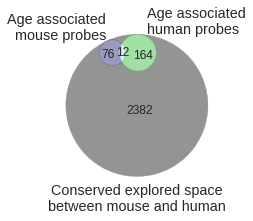

In [23]:
f, axes = plt.subplots(1, 1,figsize=(3,3))
from matplotlib_venn import venn2,venn3, venn3_circles
intersection = len(set(marker_dict_common['human']).intersection(set(marker_dict_common['mouse'])))
v = venn3(subsets=(0, 0, 0, background-(ageassociated_human+ageassociated_mouse-overlap_age_assc), ageassociated_mouse-overlap_age_assc,ageassociated_human-overlap_age_assc, overlap_age_assc), set_labels = ('Age associated\nmouse probes', 'Age associated\nhuman probes', 'Conserved explored space\nbetween mouse and human'), ax=axes)
v.get_patch_by_id('111').set_color(sns.xkcd_rgb['baby blue'])
v.get_patch_by_id('101').set_color(sns.xkcd_rgb['dark blue'])
v.get_patch_by_id('001').set_color(sns.xkcd_rgb['grey'])
v.get_patch_by_id('001').set_alpha(1)
v.get_patch_by_id('011').set_color(sns.xkcd_rgb['green'])

### Enriched regions of the commonly sampled space

Read in human annotations marked by probes

In [ ]:
#450K annotations in ENCODE data & Repeat regions
houtdir2 = 'data/evolutionary_trends/human_features_intersection/'
#newf = os.path.join(houtdir2,'160527_{}_intersects.bed'.format('AllProbes'))
newf = os.path.join(houtdir2,'ManifestPIDs_Liver_intersects.txt')
intersects_human = pd.read_csv(newf,sep='\t',header=None)
intersects_human.columns = ['chr','start','stop','sitename','feature','feature_chr','feature_start','feature_stop']
intersects_human['sitename'] =[x.split(';')[0] for x in intersects_human['sitename'].values] 
intersects_human['feature'] = [x.split('/')[-1].split('_')[1].split('.')[0] for x in intersects_human['feature'].values]
intersects_human_filter_sex = intersects_human[intersects_human['chr'].isin(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6',
       'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14',
       'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21',
       'chr22'])]
intersects_human_filter_sex_dropdups = intersects_human_filter_sex[['sitename','feature']].drop_duplicates()
human_crosstab = pd.crosstab(intersects_human_filter_sex_dropdups['sitename'],intersects_human_filter_sex_dropdups['feature'])

In [ ]:
manifest_file = 'data/evolutionary_trends/human_features_intersection/wgEncodeHaibMethyl450CpgIslandDetails.txt'
manifest = pd.read_csv(manifest_file,skiprows=range(7))
manifest = manifest[['IlmnID','CHR','UCSC_CpG_Islands_Name','UCSC_RefGene_Group',u'Relation_to_UCSC_CpG_Island', u'Phantom',u'DMR', u'Enhancer', u'HMM_Island', u'Regulatory_Feature_Name',u'Regulatory_Feature_Group', u'DHS']][:485512]
manifest = manifest[manifest['CHR'].isin(range(1,23))]
split_refgenegroup = manifest['UCSC_RefGene_Group'].str.split(';').apply(np.unique).apply(pd.Series, 1).stack()
mapping_annotations = {'TSS1500':'Promoter', 'Body':'Body', 'TSS200':'Promoter', '1stExon':'Body', "5'UTR":"5'UTR", "3'UTR":"3'UTR"}
split_refgenegroup.index = split_refgenegroup.index.droplevel(-1)
split_refgenegroup.name = 'SplitRefgeneGroup'
manifest_annotations = manifest.join(split_refgenegroup.map(mapping_annotations))
cpg_mapping = {'N_Shore':'Shore', 'S_Shelf':'Shelf', 'Island':'Island', 'S_Shore':'Shore', 'N_Shelf':'Shelf'}
manifest_annotations['CpG'] = manifest_annotations['Relation_to_UCSC_CpG_Island'].map(cpg_mapping)

In [ ]:
#450K annotations in crosstab
tt_crosstab_concat = []
manifest_annotations = manifest_annotations[manifest_annotations['CHR'].isin(range(1,23))]
for feature in ['SplitRefgeneGroup','CpG','Enhancer','DHS']:
    crosstab = pd.crosstab(manifest_annotations['IlmnID'],manifest_annotations[feature])
    if feature in ['Enhancer','DHS']:
        crosstab.columns=[feature]
    tt_crosstab_concat.append(crosstab)
crosstaball = pd.concat(tt_crosstab_concat,axis=1)
del tt_crosstab_concat
human_crosstab_all = pd.concat([human_crosstab,crosstaball])

Read in mouse space probes.

In [ ]:
#Mouse data and annotation
newf = 'data/evolutionary_trends/mouse_features_intersection/MouseIntersectFeatures_intersectedAll.txt'
intersects_pd = pd.read_csv(newf,sep='\t',header=None)
intersects_pd.columns = ['chr','start','stop','sitename','feature','feature_chr','feature_start','feature_stop']
intersects_pd['feature'] = [[x.split('/')[-1].split('_')[0],x.split('/')[-1].split('_')[1].split('.')[0]]['mapped' not in x] for x in intersects_pd['feature'].values]
intersects_pd_nodups = intersects_pd[['sitename','feature']].drop_duplicates()
gene_mapping = {'EnsemblGenes67.KnownCodingGenes.Promoters.Checked.merged':'Promoter','EnsemblExons67.KnownCodingGenes.Merged':'Body',
               'EnsemblGenes67.KnownCodingGenes.Introns.Merged':'Introns','CpGIslands':'Island','CpGShores':'Shore','CpGShelves':'Shelf','5UTR':"5'UTR",'3UTR':"3'UTR",'LINES':'LINEs','SINES':'SINEs','LTR':'LTRs'}
mapping_dict = {}
for key in intersects_pd['feature'].unique():
    if key not in gene_mapping:
        mapping_dict[key] = key
    else:
        mapping_dict[key] = gene_mapping[key]
all_features_allsites_notf_crossab = pd.crosstab(intersects_pd_nodups['sitename'],intersects_pd_nodups['feature'].map(mapping_dict))

In [ ]:
subset_mouse = all_features_allsites_notf_crossab.loc[list(set.union(*site_2_probe_dict.values())),:]
subset_human = human_crosstab_all.loc[site_2_probe_dict.keys(),:]
mouse_common_age = list(set.union(*[site_2_probe_dict[x] for x in marker_dict_common['mouse']]))
mouse_counts_removeOverlapping = calculate_odds_ratio_removeoverlapping(subset_mouse,mouse_common_age)
mouse_counts_removeOverlapping = mouse_counts_removeOverlapping.dropna()
human_counts_allAge_removeOverlapping = calculate_odds_ratio_removeoverlapping(subset_human,marker_dict_common['human'])
human_counts_allAge_removeOverlapping = human_counts_allAge_removeOverlapping.dropna()
mouse_human_OR_merged_all_rm = pd.concat([mouse_counts_removeOverlapping['OR'],human_counts_allAge_removeOverlapping['OR']],axis=1,keys=['Mouse','Human']).dropna()
logtransform_ORs = np.log(mouse_human_OR_merged_all_rm)
order = logtransform_ORs.sort_values(by=['Mouse'],ascending=[True]).index
order = [x for x in order if x not in ['SINEs','Shelf']]
pv_df_dict = {'Mouse':mouse_counts_removeOverlapping,'Human':human_counts_allAge_removeOverlapping}
colors = sns.color_palette()
f,ax = plt.subplots(1,2,figsize=(4.5,3))
#f,ax = plt.subplots(1,2)
i=0
for species in ['Mouse','Human']:
    axes = ax[i]
    np.log2(mouse_human_OR_merged_all_rm.loc[order,species]).plot(kind='barh',ax=axes,alpha=0.9,width=0.7,color=colors[i])
    axes.set_xlabel('Odds ratio of age-associated {}\nin {} (commonly profiled space)'.format('CpG sites',species.lower()))
    if i == 0:
        axes.set_ylabel('Regions')
    else:
        axes.set_yticks([])
    for tick in axes.get_xticklabels():
        tick.set_fontsize(5)
    for j,feature in enumerate(order):
        df_vals = pv_df_dict[species]
        pv_val = df_vals.loc[feature,'pvalue']
        height = np.log2(df_vals.loc[feature,'OR'])
        if pv_val < 0.05/(len(order)*2):
            axes.annotate('*',xy=(height+[0.3,-0.3][height<0],j-.3),fontsize=9)
    axes.set_xlim([-3,3])
    t=axes.set_xticks([x for x in range(-3,4)])
    t=axes.set_xticklabels([round(2**x,2) for x in range(-3,4)])
    for m in range(len(mouse_human_OR_merged_all_rm.index.unique())):
        axes.axhline(m+.5,color='grey',ls='--',lw=0.5)
    i=i+1
f.tight_layout()
sns.despine()
f.subplots_adjust(wspace=0.75)
f.savefig('plots/OddsRatio_AllAgeSites_removeOverlapping_CommonSpace_PublicRRBS.pdf',dpi=700,bbox_inches='tight')
plt.show()
plt.close()

In [43]:
pv_df_dict

{'Human':              Feature        OR        pvalue
 Feature                                     
 3'UTR          3'UTR  0.000000  2.543073e-01
 5'UTR          5'UTR  0.821525  3.273883e-01
 Bivalent    Bivalent  1.738300  3.498462e-02
 Body            Body  0.895588  5.095605e-01
 DNAse          DNAse  0.672502  1.310234e-02
 Enhancers  Enhancers  0.558242  8.254769e-04
 H3K27ac      H3K27ac  0.377767  4.381624e-07
 H3K27me3    H3K27me3  1.986952  2.318690e-02
 H3K36me3    H3K36me3  1.239793  3.684051e-01
 H3K4me1      H3K4me1  2.012929  5.023962e-02
 H3K4me3      H3K4me3  0.769606  4.720091e-01
 H3K9ac        H3K9ac  0.478460  1.580094e-03
 H3K9me3      H3K9me3  1.665550  6.283981e-01
 Island        Island  1.811560  2.780742e-02
 LINEs          LINEs  0.000000  6.200343e-01
 LTRs            LTRs  0.000000  1.000000e+00
 Promoter    Promoter  1.001955  1.000000e+00
 SINEs          SINEs  0.774603  1.000000e+00
 Shelf          Shelf  1.044434  1.000000e+00
 Shore          Shore  0.

### Age association trends with no respect to conservation

For this section we made use of our multiple datasets in order to identify age associated sites. We carried out our drop1 F-test in two stages. FOr mice, we used Reizel to identify age-associated sites at a 1% FDR, then we used Orozco and Cannon to see if these sites still had an age-association at 1% FDR. For humans, we used GSE61258 to identify CpG markers at 1% FDR and then used GSE48325 to see if these age associated sites still had an age-association at a 1% FDR. For mice, we controlled for gender+treatment+study, for humans, we controlled for gender+study+bmi. Using the same script as above (y)

In [34]:
dropLRT_dicts_h2stage = {}
outdh = 'data/evolutionary_trends/human_age_association_results/'
results_dir = os.path.join(outdh,'humanOnly_2stage')
#dropLRT_cfig_lines_dict = {'Hannum':['Age','Age;gender'],'EPIC':['Age','Age;gender'],'Reizel':['age_days','age_days;gender;treatment'],'Adams_NotReizel':['age_days','age_days;study;treatment']}
#dropLRT_cfig_lines_dict = {'Reizel':['age_days','age_days;gender;treatment']}
covar_map_dict = {'human':{'covar_string':'age;Sex;bmi','drop':'age'}}
age_key = 'age'
for key in ['Discovery','Validation']:
    flist = twto.make_files_tuple(results_dir,key)
    concatdf = []
    for fname,results_f in flist:
        df = pd.read_csv(results_f,sep='\t',header=0,index_col=0)
        df2save = df.loc[age_key,['pvalues_droponly','marker']]
        concatdf.append(df2save)
    df2save_nonans = pd.concat(concatdf).dropna()
    df2save_nonans['fdr_bh'] = smstats.multicomp.multipletests(df2save_nonans['pvalues_droponly'],method='fdr_bh')[1]
    dropLRT_dicts_h2stage[key]=df2save_nonans

In [35]:
marker_dict_human_2stage = {}
fdrcut = 0.01
key='Discovery'
#for key in dropLRT_dicts_h2stage:
df = dropLRT_dicts_h2stage[key]
markers = df.loc[df.fdr_bh<fdrcut,'marker']
marker_dict_human_2stage[key] = markers

In [36]:
key='Validation'
#for key in dropLRT_dicts_h2stage:
df = dropLRT_dicts_h2stage[key]
df = df[df.marker.isin(marker_dict_human_2stage['Discovery'])].dropna()
df['fdr_bh'] = smstats.multicomp.multipletests(df['pvalues_droponly'],method='fdr_bh')[1]
markers = df.loc[df.fdr_bh<fdrcut,'marker']
marker_dict_human_2stage[key] = markers

In [37]:
dropLRT_dicts_m2stage = {}
results_dir = 'data/evolutionary_trends/mouse_age_association_results/all_space/'
age_key = 'age_days'
for key in ['Discovery','Validation']:
    flist = twto.make_files_tuple(results_dir,key)
    concatdf = []
    for fname,results_f in flist:
        df = pd.read_csv(results_f,sep='\t',header=0,index_col=0)
        df2save = df.loc[age_key,['pvalues_droponly','marker']]
        concatdf.append(df2save)
    df2save_nonans = pd.concat(concatdf).dropna()
    df2save_nonans['fdr_bh'] = smstats.multicomp.multipletests(df2save_nonans['pvalues_droponly'],method='fdr_bh')[1]
    dropLRT_dicts_m2stage[key]=df2save_nonans

In [38]:
marker_dict_mouse_2stage = {}
fdrcut = 0.01
key='Discovery'
#for key in dropLRT_dicts_h2stage:
df = dropLRT_dicts_m2stage[key]
markers = df.loc[df.fdr_bh<fdrcut,'marker']
marker_dict_mouse_2stage[key] = markers

In [39]:
key='Validation'
#for key in dropLRT_dicts_h2stage:
df = dropLRT_dicts_m2stage[key]
df = df[df.marker.isin(marker_dict_mouse_2stage['Discovery'])].dropna()
df['fdr_bh'] = smstats.multicomp.multipletests(df['pvalues_droponly'],method='fdr_bh')[1]
markers = df.loc[df.fdr_bh<fdrcut,'marker']
marker_dict_mouse_2stage[key] = markers

In [40]:
for key in marker_dict_human_2stage:
    print key, len(marker_dict_human_2stage[key])

Validation 322
Discovery 370


In [41]:
for key in marker_dict_mouse_2stage:
    print key, len(marker_dict_mouse_2stage[key])

Validation 393
Discovery 1188


We calculate the entropy for the discovery datasets using the validated age-associated markers

In [42]:
entropy_age_reizel = entropy(df_reizelonly,marker_dict_mouse_2stage['Validation'])
entropy_61 = entropy(gse_61,marker_dict_human_2stage['Validation'])

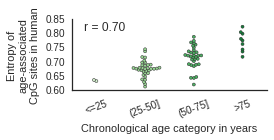

In [47]:
color_pallete_human = sns.color_palette("Greens",4)
fsize=(4,2)
f,axes = plt.subplots(1,1,figsize=fsize)
#f,axes = plt.subplots(1,1)
ax = sns.swarmplot(x=covs_61['Age category'],y=entropy_61,order=['<=25','(25-50]','(50-75]','>75'],size=3,
                   palette=color_pallete_human,ax=axes,linewidth=0.5)
ax.set_ylabel('Entropy of\nage-associated\nCpG sites in human')
ax.set_xlabel('Chronological age category in years')
#ax.set_title('Entropy of human age sites')
yticks2plot = ax.get_yticks()
#ax.set_yticks(yticks2plot)
#ax.annotate('r = {}'.format(round(categorizing_humans['Age'].corr(entropy_human_age),2)),xy=(-0.25,ax.get_ylim()[1]-1.5*(yticks2plot[1]-yticks2plot[0])/2),fontsize=8)
ax.annotate('r = {0:.2f}'.format(round(covs_61['age'].corr(entropy_61),2)),xy=(-0.25,ax.get_ylim()[1]-1.5*(yticks2plot[1]-yticks2plot[0])/2))
for tick in axes.get_xticklabels():
    tick.set_rotation(20)
sns.despine()

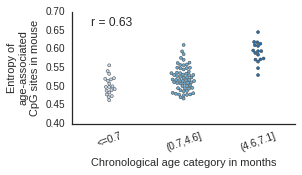

In [49]:
fsize=(4,2)
f,axes = plt.subplots(1,1,figsize=fsize)
#f,axes = plt.subplots(1,1)
color_pallete_human = sns.color_palette("Greens",4)
color_pallete_mouse = sns.color_palette("Blues",3)
ax = sns.swarmplot(x=covariates_reizel['Age category'],y=entropy_age_reizel,palette=color_pallete_mouse,ax=axes,linewidth=0.5,size=3)
ax.set_xlabel('Chronological age category in months')
ax.set_ylabel('Entropy of\nage-associated\nCpG sites in mouse')
ax.annotate('r = {0:.2f}'.format(round(covariates_reizel['age_days'].corr(entropy_age_reizel),2)),xy=(-0.25,ax.get_ylim()[1]-1.5*(yticks2plot[1]-yticks2plot[0])/2))
for tick in axes.get_xticklabels():
    tick.set_rotation(20)
sns.despine()